In [1]:
!pip install inference

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.2/412.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.7/239.7 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
from tensorflow.keras.models import load_model
from keras.models import load_model
from keras.preprocessing import image

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
from inference import get_model
from google.colab import files
import supervision as sv
import cv2

In [16]:
%cd '/content/gdrive/MyDrive/Colab Notebooks/Spine_Dataset'

/content/gdrive/MyDrive/Colab Notebooks/Spine_Dataset


In [34]:
# Load the InceptionV3 model
inception_v3_handle = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4"
inception_v3_layer = hub.KerasLayer(inception_v3_handle)

# Define a custom_objects dictionary that maps the layer name to the actual class
custom_objects = {'KerasLayer': inception_v3_layer}

# Load the model with the custom_objects dictionary
inception_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab/inception_spine.h5', custom_objects=custom_objects)

In [35]:
plt.figure(figsize=(10, 10))

uploaded=files.upload()

Saving 2.png to 2 (2).png


<Figure size 1000x1000 with 0 Axes>

In [36]:
# get the name of the uploaded file
uploaded_filename = next(iter(uploaded))

# define the image url to use for inference
image_file = "/content/gdrive/MyDrive/Colab Notebooks/Spine_Dataset/" + uploaded_filename
image = cv2.imread(image_file)

In [37]:
# import the inference-sdk
from inference_sdk import InferenceHTTPClient

# initialize the client
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="WDK4qZzpJ4j5CMWpDwLf"
)

# infer on a local image
results = CLIENT.infer(image_file, model_id="dendritic-spine-object-detection/2")

In [38]:
# load the results into the supervision Detections api
detections = sv.Detections.from_inference(results)

1/1 [==============================] - 0s 125ms/step


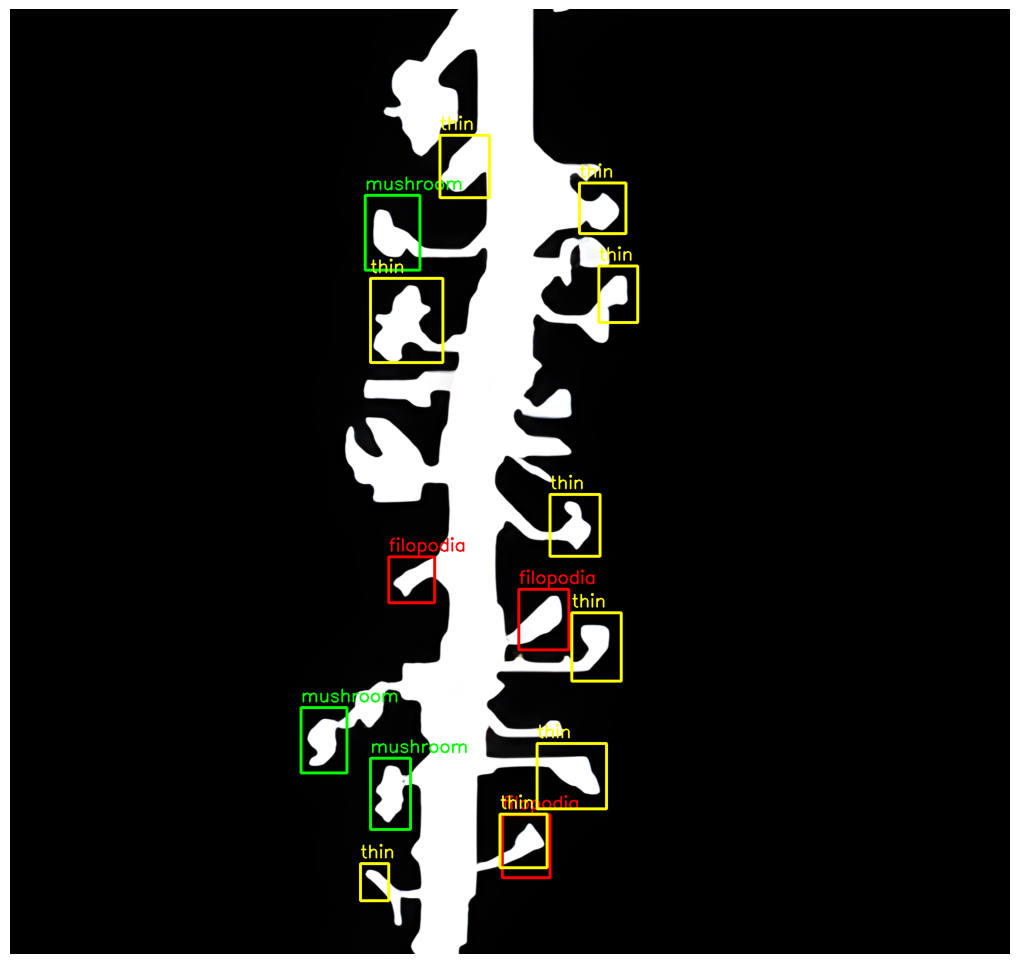

In [39]:
# Define a dictionary of class names and their corresponding colors in BGR format
class_colors = {
    'filopodia': (0, 0, 255),  # Red
    'mushroom': (0, 255, 0),  # Green
    'stubby': (255, 0, 0),    # Blue
    'thin': (0, 255, 255)     # Yellow
}

# iterate over each detection
for i, bbox in enumerate(detections.xyxy):
    # get the bounding box coordinates
    x1, y1, x2, y2 = [int(x) for x in bbox]

    # crop the detected object from the image
    cropped_img = image[int(y1):int(y2), int(x1):int(x2)]

    # preprocess the cropped image for Custom Classification Model
    cropped_img_resized = cv2.resize(cropped_img, (224, 224))  # Resize to (224, 224)
    cropped_img_resized = cv2.cvtColor(cropped_img_resized, cv2.COLOR_BGR2RGB)  # Convert to RGB
    cropped_img_resized = np.expand_dims(cropped_img_resized, axis=0)  # Add extra dimensions
    cropped_img_resized = cropped_img_resized / 255.0  # Normalize

    # classify the object
    prediction = inception_model.predict(cropped_img_resized)
    class_names = ['filopodia', 'mushroom', 'stubby', 'thin']
    object_class = class_names[np.argmax(prediction)]

    # get the color and color name for the class
    color = class_colors.get(object_class, (0, 0, 0))  # Default to black if class not found

    # draw the bounding box and label on the original image with the assigned color
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 3)  # Increase thickness to 3
    cv2.putText(image, f"{object_class}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)  # Increase font size to 1.5

# display the image with annotated classes
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# remove padding and margin
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

# save the image to your Google Drive
plt.savefig('/content/gdrive/MyDrive/Colab/annotated_results/annotated_image8.png', bbox_inches = 'tight', pad_inches = 0)

plt.show()